# Notebook Usage

Should you have any question, please contact Randy Wang(ruotongw@nvidia.com).

## 1. Complie

Add `-DENABLE_PROFILING=ON` when pass args to Cmake. And then do the normal `make` process.


## 2. Config schedule

Comment out anything you are not interested in `dlrm_perf_schedule` below. Just comment the event label line, don't comment out
the `forward_events`, `backward_events` or `BottomMLP.fc1` line. You can check for all labels in the cpp code. And also you can add
your own label and recompile it, then insert correspond label in `dlrm_perf_schedule`.


In [1]:
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 1000px; }</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))

import sys
import os
from datetime import datetime
from shutil import copy
import json

from IPython.display import display

project_root = os.path.join(os.path.abspath(''), '..', '..')
sys.path.append(project_root)

from tools.profiler import generate_schedule, parse_result
from tools.profiler.chart import timeline_chart, scaling_chart

dlrm_perf_schedule = {
    # interested event name
    'BottomMLP.fc1': {
        'forward_events': [
            'fused_relu_bias_fully_connected.fprop',
#            'fused_relu_bias_fully_connected.fprop.cublasLtMatmul',
        ],
        'backward_events': [
            'fused_relu_bias_fully_connected.bprop',
#            'fused_relu_bias_fully_connected.bprop.initialize_array',
#            'fused_relu_bias_fully_connected.bprop.reverse_add_bias_and_re_kernel',
#            'fused_relu_bias_fully_connected.bprop.convert_array',
#            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_1',
#            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_2'
        ]
    },
    'BottomMLP.fc2': {
        'forward_events': [
            'fused_relu_bias_fully_connected.fprop',
#            'fused_relu_bias_fully_connected.fprop.cublasLtMatmul',
        ],
        'backward_events': [
            'fused_relu_bias_fully_connected.bprop',
#            'fused_relu_bias_fully_connected.bprop.initialize_array',
#            'fused_relu_bias_fully_connected.bprop.reverse_add_bias_and_re_kernel',
#            'fused_relu_bias_fully_connected.bprop.convert_array',
#            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_1',
#            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_2'
        ]
    },
    'BottomMLP.fc3': {
        'forward_events': [
            'fused_relu_bias_fully_connected.fprop',
#            'fused_relu_bias_fully_connected.fprop.cublasLtMatmul',
        ],
        'backward_events': [
            'fused_relu_bias_fully_connected.bprop',
#            'fused_relu_bias_fully_connected.bprop.initialize_array',
#            'fused_relu_bias_fully_connected.bprop.reverse_add_bias_and_re_kernel',
#            'fused_relu_bias_fully_connected.bprop.convert_array',
#            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_1',
#            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_2'
        ]
    },
    'sparse_embedding1': {
        'forward_events': [
            'localized_slot_sparse_embedding_one_hot.forward',
            'all2all_forward',
            'inter_node_hier_a2a.fprop'
        ],
        'backward_events': [
            'localized_slot_sparse_embedding_one_hot.backward',
            'all2all_backward',
            'inter_node_hier_a2a.bprop',
            'localized_slot_sparse_embedding_one_hot.update_params'
        ]
    },
    'interaction1': {
        'forward_events': [
            'interaction.fprop'
        ],
        'backward_events': [
            'interaction.bprop'
        ]
    },
    'TopMLP.fc4': {
        'forward_events': [
            'fused_relu_bias_fully_connected.fprop',
#            'fused_relu_bias_fully_connected.fprop.cublasLtMatmul',
        ],
        'backward_events': [
            'fused_relu_bias_fully_connected.bprop',
#            'fused_relu_bias_fully_connected.bprop.initialize_array',
#            'fused_relu_bias_fully_connected.bprop.reverse_add_bias_and_re_kernel',
#            'fused_relu_bias_fully_connected.bprop.convert_array',
#            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_1',
#            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_2'
        ]
    },
    'TopMLP.fc5': {
        'forward_events': [
            'fused_relu_bias_fully_connected.fprop',
#            'fused_relu_bias_fully_connected.fprop.cublasLtMatmul',
        ],
        'backward_events': [
            'fused_relu_bias_fully_connected.bprop',
#            'fused_relu_bias_fully_connected.bprop.initialize_array',
#            'fused_relu_bias_fully_connected.bprop.reverse_add_bias_and_re_kernel',
#            'fused_relu_bias_fully_connected.bprop.convert_array',
#            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_1',
#            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_2'
        ]
    },
    'TopMLP.fc6': {
        'forward_events': [
            'fused_relu_bias_fully_connected.fprop',
#            'fused_relu_bias_fully_connected.fprop.cublasLtMatmul',
        ],
        'backward_events': [
            'fused_relu_bias_fully_connected.bprop',
#            'fused_relu_bias_fully_connected.bprop.initialize_array',
#            'fused_relu_bias_fully_connected.bprop.reverse_add_bias_and_re_kernel',
#            'fused_relu_bias_fully_connected.bprop.convert_array',
#            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_1',
#            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_2'
        ]
    },
    'TopMLP.fc7': {
        'forward_events': [
            'fused_relu_bias_fully_connected.fprop',
#            'fused_relu_bias_fully_connected.fprop.cublasLtMatmul',
        ],
        'backward_events': [
            'fused_relu_bias_fully_connected.bprop',
#            'fused_relu_bias_fully_connected.bprop.initialize_array',
#            'fused_relu_bias_fully_connected.bprop.reverse_add_bias_and_re_kernel',
#            'fused_relu_bias_fully_connected.bprop.convert_array',
#            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_1',
#            'fused_relu_bias_fully_connected.bprop.cublasGemmEx_2'
        ]
    },
    'TopMLP.fc8': {
        'forward_events': [
            'fully_connected_layer_half.fprop',
#            'fully_connected_layer_half.fprop.cublasGemmEx_1',
#            'fully_connected_layer_half.fprop.cublasGemmEx_2'
        ],
        'backward_events': [
            'fully_connected_layer_half.bprop',
#            'fully_connected_layer_half.bprop.cublasGemmEx_1',
#            'fully_connected_layer_half.bprop.cublasGemmEx_2',
#            'fully_connected_layer_half.bprop.cublasGemmEx_3'
        ]
    },
    'Loss': {
        'forward_events': [
            'compute'
        ]
    },
    'AllReduce_wgrads': {
        'forward_events': [
            'exchange_wgrad'
        ]
    },
    'Update_Params': {
        'forward_events': [
            'update'
        ]
    }
}

## 3. Set config and generate the profiling dir

In [2]:
# Define profiling_dir for this profiling session.
# Specify the config file you want to use. Also other configs, like slurm related.
working_dir = os.path.join('tools', 'profiler')
# train configs
config_name = '43008_8gpus'
config_file = os.path.join('mlperf', 'configs', config_name + '.json')
# slurm related
nodes_num = 1
container_name = 'hugectr-dlrm-profiling'
image = 'gitlab-master.nvidia.com/dl/mlperf/optimized:recommendation.hugectr.2035814'
mounts_str = '/raid:/raid,/lustre/fsw/mlperft-dlrm/ruotongw/hugectr:/etc/workspace/home'
account = 'mlperft-dlrm'
jobid = '1069007'
# profiler related
profiling_dir_name = 'dgxa100_{nodes_num}node_'.format(nodes_num=nodes_num) + config_name
profiling_dir = os.path.join(working_dir, 'results', profiling_dir_name)

## 4. Generate the profiling dir

In [ ]:
# create if profiling_dir non-exist.
os.makedirs(os.path.join(project_root, profiling_dir), exist_ok=True)
# Copy config to profiling_dir, for backup
copy(os.path.join(project_root, config_file), os.path.join(project_root, profiling_dir))
# Create a prof.schedule in profiling_dir. This file will instruct cpp profiler how to prof.
# If you are not on cluster, you need to somehow upload the profiling dir to the corresponding
# location on cluster. 
generate_schedule(dlrm_perf_schedule, os.path.join(project_root, profiling_dir))

## 5. Run the training

### 5.a on the cluter, in the login node

You may want to first
```
salloc -p luna -A {account} -N{nodes_num} bash
```
to apply for resources in advance. Remeber the jobid and fill in above.

The hugectr will exit after the profiling is completed, usually only run for 1000 - 3000 iters, depends on how many
interested events you defined in the dlrm_perf_schedule. The raw result will appear in profiling_dir as ${host_name}.prof.json.
If you use multiple nodes, there will be several jsons appear. The result json is not human readable, so please use function below to parse it.

In [ ]:
cmd = '''
    srun --mpi=pmix --ntasks="{nodes_num}" --ntasks-per-node=1 --container-workdir /etc/workspace/home \\
         --container-name="{container_name}" --container-mounts="{mounts_str}" --container-image={image} \\
         --export=NCCL_LAUNCH_MODE=PARALLEL,PROFILING_DIR={profiling_dir} -A {account} --jobid={jobid}\\
         numactl --interleave=all ./build/bin/huge_ctr --train {config_file}
'''.format(mounts_str=mounts_str, nodes_num=nodes_num, image=image, container_name=container_name,
           profiling_dir=profiling_dir, config_file=config_file, account=account, jobid=jobid)
print(cmd)
!$cmd

### 5.b If you are already in the hugectr container, you have to run the trainning with env PROFILING_DIR, like:

    export NCCL_LAUNCH_MODE=PARALLEL
    export PROFILING_DIR={profiling_dir in the container}
    numactl --interleave=all ./build/bin/huge_ctr --train {config_file}

## 5. Result

The hugectr will exit after the profiling is completed, usually only run for 1000 - 3000 iters, depends on how many
interested events you defined in the `dlrm_perf_schedule`. The raw result will appear in `profiling_dir` as
`${host_name}.prof.json`. If you use multiple nodes, there will be several jsons appear. The result json is not
human readable, so please use function below to parse it.

In [5]:
profiling_dir = "tools/profiler/results/test"
# Parse the result into more human readable format.
result = parse_result(os.path.join(project_root, profiling_dir))
# print adn save the result
with open(os.path.join(project_root, profiling_dir, profiling_dir_name + '.json'), 'w') as f:
    json.dump(result, f, indent=2)
print(json.dumps(result, indent=2))
# And you can do anything you like, for instance drawing all kinds of chart from the result

[
  {
    "host_name": "luna-0061",
    "avg_iter_time_ms": 2.3764277455062977,
    "timeline": {
      "device_0": {
        "stream_0": [
          {
            "label": "sparse_embedding1.localized_slot_sparse_embedding_one_hot.forward",
            "avg_measured_time_ms": 0.32188865238306474,
            "avg_iter_start_to_event_start_time_ms": 0.11433534673890289
          },
          {
            "label": "BottomMLP.fc1.fused_relu_bias_fully_connected.fprop",
            "avg_measured_time_ms": 0.035147101827421964,
            "avg_iter_start_to_event_start_time_ms": 0.5049175504519015
          },
          {
            "label": "BottomMLP.fc2.fused_relu_bias_fully_connected.fprop",
            "avg_measured_time_ms": 0.02173714275110741,
            "avg_iter_start_to_event_start_time_ms": 0.5171898773738316
          },
          {
            "label": "interaction1.interaction.fprop",
            "avg_measured_time_ms": 0.057739755024715345,
            "avg_iter_start_t

<IPython.core.display.Javascript object>


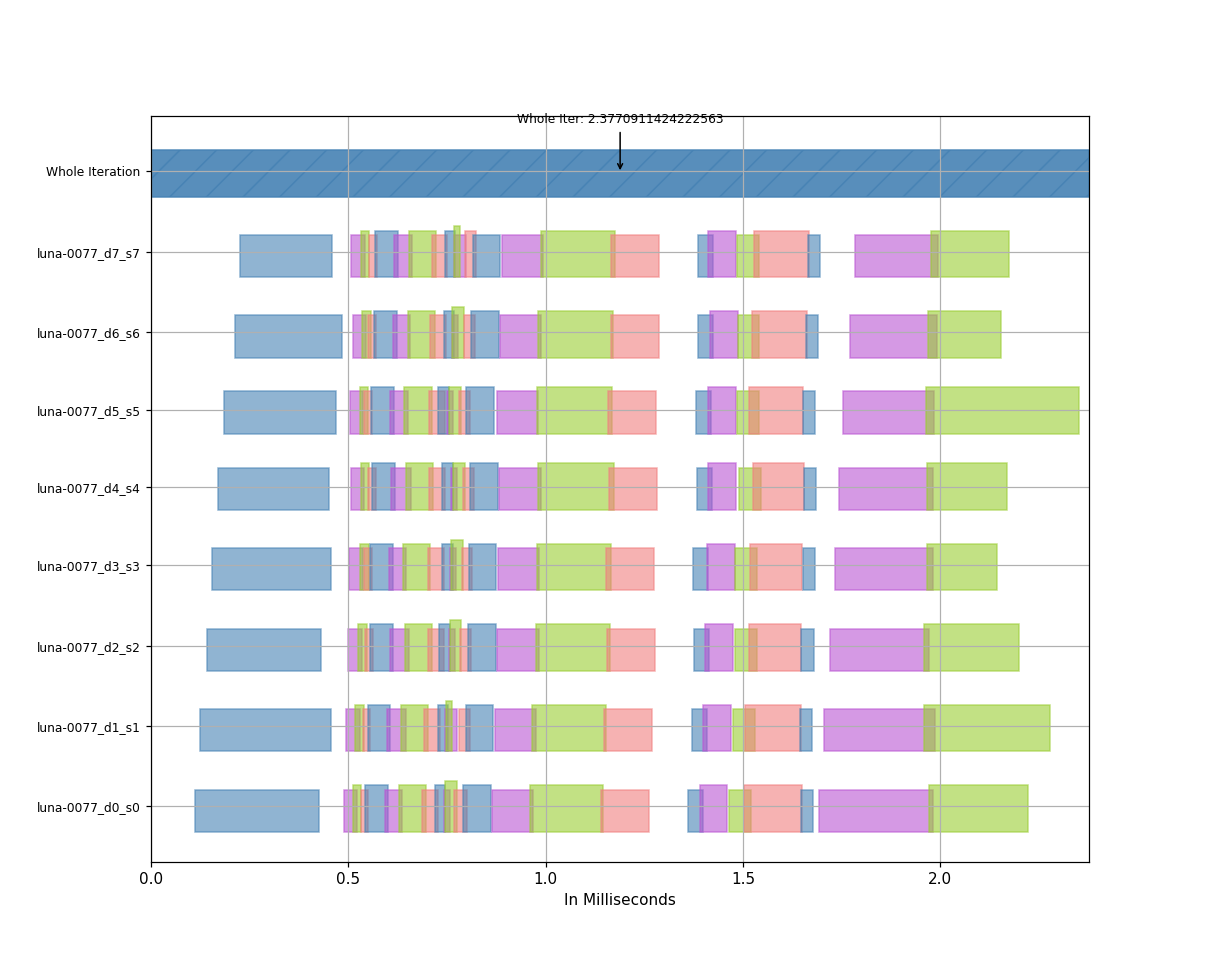

In [4]:
# Draw a timeline chart
timeline_chart(result)

In [ ]:
profiling_dirs = [
    os.path.join(project_root, 'tools', 'profiler', 'results', 'dgxa100_1node_43008_8gpus'),
    os.path.join(project_root, 'tools', 'profiler', 'results', 'dgxa100_1node_55296_8gpus'),
]
results = []
names = ['dgxa100_1node_43008_8gpus', 'dgxa100_1node_55296_8gpus']
for prof_dir in profiling_dirs:
    names.append(prof_dir)
    results.append(parse_result(prof_dir))
    
# draw scaling chart
scaling_chart(results, names)